**Objetivo:** Analizar la eficacia de una cópula no paramétrica en la representación de la dependencia no lineal entre dos variables, con el fin de comprender mejor su capacidad para modelar relaciones complejas.

**Contexto:** Se tiene información sobre la concentración de mineral a nivel porcentual (%) en un banco de minería a cielo abierto a nivel detallada, desde ahora "Z2". Sin embargo existen otras variables como por ejemplo la "Recuperación Metalurgica", desde ahora "Z1", la cual esta sub muestreada o en menor cantidad. 

En este ejemplo se posee la variable Z2, más la variable Z1 se construira artificialmente emulando una relación no lineal. 

- **Z2** = Variable secundaria (independiente) mayormente muestreada: Grado o concentración mineral (medida en %).
- **Z1** = Variable primaria ***artificial*** (dependiente) menormente muestreada: Recuperación metalurgica (medida en %). 

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import openturns as ot
import openturns.viewer as otv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

**1. Importar y transformar datos:** 

In [2]:
df = pd.read_csv("barrenos_banco.csv", sep=";")
scaler = StandardScaler()
# Las coordenadas y el grado mineral (Z2) se transformaran por cuestiones de confidencialidad en los datos. 
df[['X', 'Y']] = scaler.fit_transform(df[['X', 'Y']])
df["Z2"] = df["Z2"]*2.99 
df = df[df["Z2"] <= 3] #se eliminan un par de "valores atipicos".
df.head(1)

,LONG,X,Y,Z2
0,14.6,1.285531,2.404668,0.43953


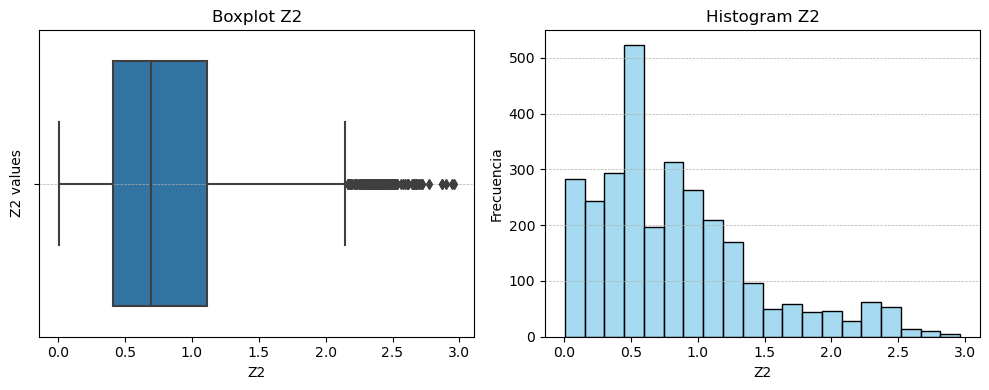

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(x=df["Z2"].dropna(), ax=axs[0])
axs[0].set_title('Boxplot Z2')
axs[0].set_ylabel('Z2 values')
axs[0].grid(axis='y', linestyle='--', linewidth=0.5)
sns.histplot(df["Z2"].dropna(), bins=20, color='skyblue', edgecolor='black', ax=axs[1])
axs[1].set_title('Histogram Z2')
axs[1].set_xlabel('Z2')
axs[1].set_ylabel('Frecuencia')
axs[1].grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**2. Visualización Z2 (variable independiente):**

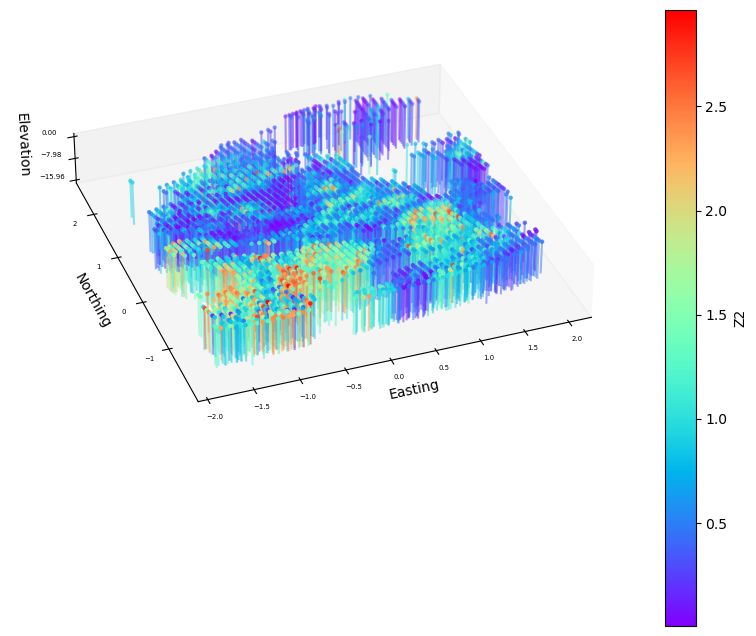

In [4]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['X'], df['Y'], 0, c=df['Z2'], cmap='rainbow', s=5) #la unidad de medida de Z2 es "%"
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Elevation')
for x, y, z, c in zip(df['X'], df['Y'], df['LONG'], df['Z2']):
    ax.plot([x, x], [y, y], [0, -z], color=sc.cmap(sc.norm(c)), alpha=0.5)

ax.view_init(elev=35, azim=250)
ax.grid(False)
cb = plt.colorbar(sc, orientation='vertical', ax=ax)
cb.set_label('Z2')
cb.ax.tick_params(labelsize=10)

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.2, 1]))
ax.set_zticks(np.linspace(-df['LONG'].max(), 0, 3)) 
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=5)
ax.tick_params(axis='z', labelsize=5)

plt.show()

**3. Construcción de Z1 (no lineal con respecto a Z2):**

In [5]:
df['Z1_C'] = 4 - (df['Z2'] - 1.3)**2 + np.random.normal(0, 0.3, len(df))
Z1_C = MinMaxScaler(feature_range=(60, 95)) #se escala para que se mueva entre 60 y 95 % de recuperación.
df['Z1_C'] = Z1_C.fit_transform(df[['Z1_C']])

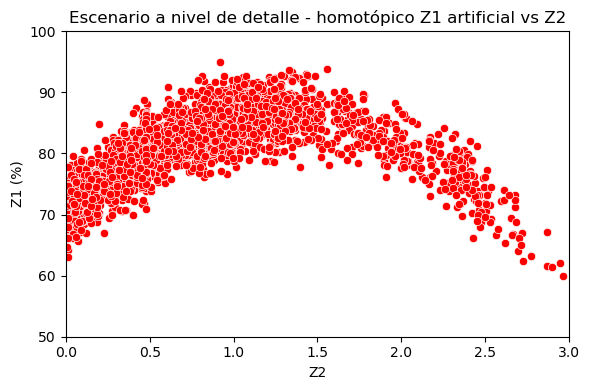

Este escenario es la base de la cual se extraerá la muestra para Z1.


In [6]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='Z2', y='Z1_C', color="red")
plt.xlabel('Z2')
plt.ylabel('Z1 (%)')
plt.title("Escenario a nivel de detalle - homotópico Z1 artificial vs Z2")
plt.xlim(0, round(max(df["Z2"]) + 0.5))
plt.ylim(50, 100)
plt.tight_layout()
plt.show()
print("Este escenario es la base de la cual se extraerá la muestra para Z1.")


**4. Guardar tablas de datos completa y parcial:** Se muestreara al 10% la variable Z1 y se creara el escenario a trabajar.

Se creara una muestra parcial de las variables dependientes Z1 para la construcción de la copula. Posterior construir el modelo de dependencia con copulas, se compararan las estimaciones con respecto a los valores reales.

In [7]:
df_real = df.copy()
df_real.to_csv("datos_banco_completo.csv", index=False)
indice_max = df_real["Z2"].idxmax()
fila_max = df_real.loc[indice_max].copy()
num_filas_eliminar = int(df['Z1_C'].count() * 0.95) #solo se trabajará con el 5% de los datos para Z1
indices_eliminar = df[['Z1_C']].sample(num_filas_eliminar, random_state=42).index
df_test = df.loc[indices_eliminar]
df_test.to_csv("datos_banco_test.csv", index=False)
df.loc[indices_eliminar, ['Z1_C']] = None
df_train = df.loc[~df.index.isin(indices_eliminar)]
df_train = df_train.append(fila_max, ignore_index=True)
df_train.to_csv("datos_banco_train.csv", index=False)

print("Número total de datos: ", df_real["Z1_C"].count(), "homotópicos")
print("Número de datos para entrenamiento de la copula: ", df_train["Z1_C"].count(), ", (10%)", " Z1 sub-muestreado")
print("Número de datos para la prueba del modelo: ", df_test["Z1_C"].count(), ", (90%)")


Número total de datos:  2961 homotópicos
Número de datos para entrenamiento de la copula:  150 , (10%)  Z1 sub-muestreado
Número de datos para la prueba del modelo:  2812 , (90%)


**5. Datos con dependencia NO LINEAL:** La variable independiente (Z2) debe quedar con la misma cantidad de valores que la sub-muestreada (Z1).

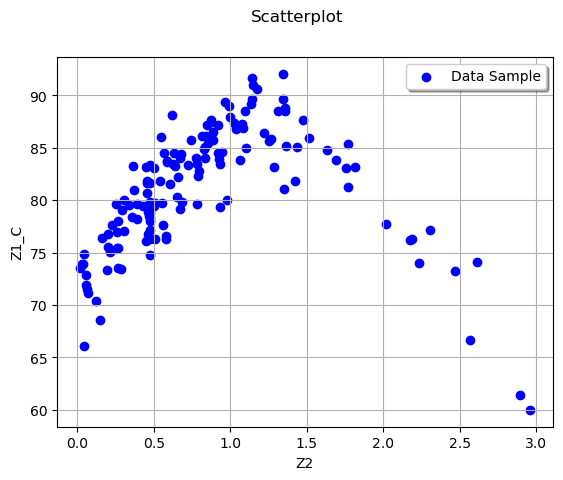

In [8]:
df1 = pd.read_csv("datos_banco_train.csv", sep=",")

columnas= ['Z2','Z1_C'] #prueba con dependencia NO LINEAL
df1 = df1[columnas]
df = df1.dropna()
sample = ot.Sample(df.values)
sample.setDescription(['Z2', 'Z1_C'])

n_var = sample.getDimension()
sample_size=sample.getSize()
name_var1=sample.getDescription()[0]
name_var2=sample.getDescription()[1]
label_var1=name_var1
label_var2=name_var2
var1=sample[:,0] #VAR1 = Z2 = VARIABLE INDEPENDIENTE
var1.setName(label_var1)
var2=sample[:,1] #VAR2 = Z1 = VARIABLE DEPENDIENTE
var2.setName(label_var2)

cloud_DS = ot.Cloud(sample, "blue", "fcircle","Data Sample")
figure_DS = ot.Graph("Scatterplot", label_var1, label_var2, True, "topright")
figure_DS.add(cloud_DS)
view=otv.View(figure_DS)
view.save("asdas_scatterplot.png",dpi=200)

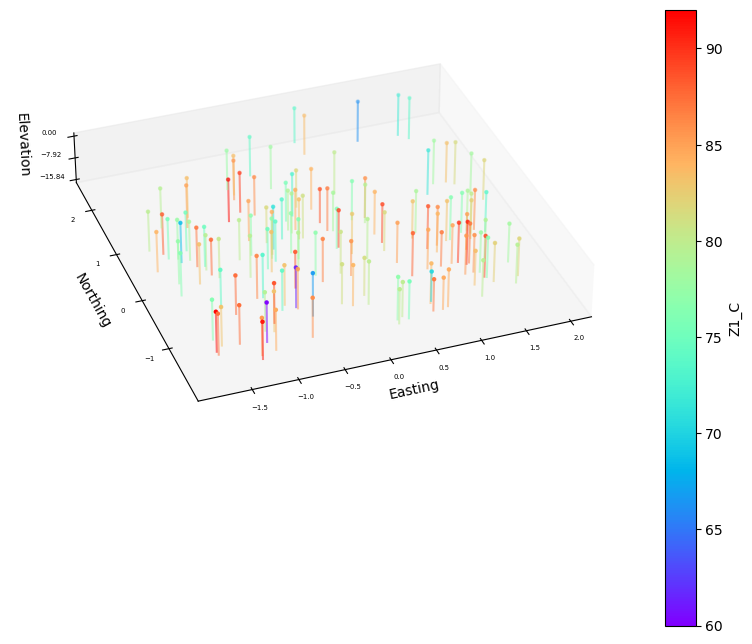

In [9]:
df_train = pd.read_csv("datos_banco_train.csv", sep=",")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_train['X'], df_train['Y'], 0, c=df_train['Z1_C'], cmap='rainbow', s=5) #la unidad de medida de Z2 es "%"
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Elevation')
for x, y, z, c in zip(df_train['X'], df_train['Y'], df_train['LONG'], df_train['Z1_C']):
    ax.plot([x, x], [y, y], [0, -z], color=sc.cmap(sc.norm(c)), alpha=0.5)

ax.view_init(elev=35, azim=250)
ax.grid(False)
cb = plt.colorbar(sc, orientation='vertical', ax=ax)
cb.set_label('Z1_C')
cb.ax.tick_params(labelsize=10)

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.2, 1]))
ax.set_zticks(np.linspace(-df_train['LONG'].max(), 0, 3)) 
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=5)
ax.tick_params(axis='z', labelsize=5)

plt.show()

**MODELADO DE CÓPULA NO PARAMÉTRICA CON KERNEL SMOOTHING (KS)**

**6. ESTIMACIÓN DE DISTRIBUCIONES MARGINALES CON KS:**

In [10]:
kernel_distribution=ot.Epanechnikov()

kernel = ot.KernelSmoothing(kernel_distribution)
estimated_kernel_var1= kernel.build(var1) #Z2 = VARIABLE INDEPENDIENTE 
estimated_kernel_var2= kernel.build(var2) #Z1 = VARIABLE DEPENDIENTE 

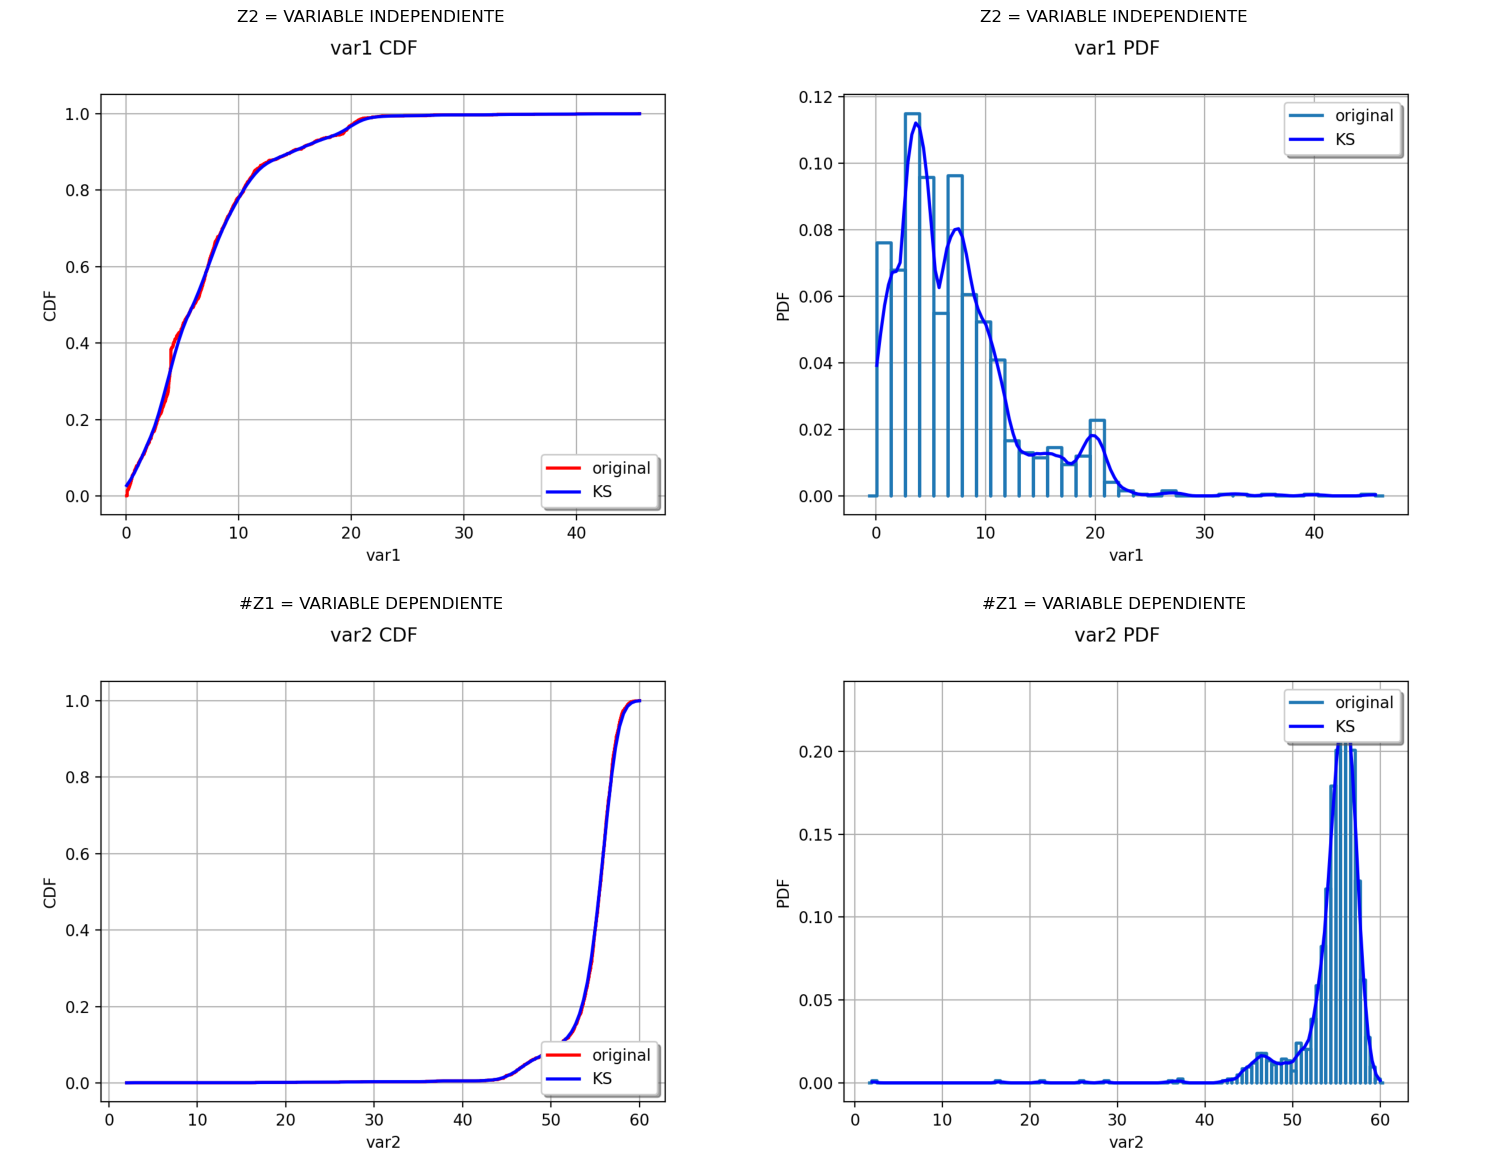

In [11]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.imshow(plt.imread("label_var1.png"))
plt.axis('off')
plt.title("Z2 = VARIABLE INDEPENDIENTE ")
plt.subplot(2, 2, 2)
plt.imshow(plt.imread("label_var1_hist.png"))
plt.axis('off')
plt.title("Z2 = VARIABLE INDEPENDIENTE ")
plt.subplot(2, 2, 3)
plt.imshow(plt.imread("label_var2.png"))
plt.axis('off')
plt.title("#Z1 = VARIABLE DEPENDIENTE ")
plt.subplot(2, 2, 4)
plt.imshow(plt.imread("label_var2_hist.png"))
plt.axis('off')
plt.title("#Z1 = VARIABLE DEPENDIENTE ")
plt.tight_layout()
plt.show()

**7. Ajuste de una cópula no paramétrica utilizando KS:**

In [12]:
KernelSmoothing_copula_distribution = ot.KernelSmoothing(kernel_distribution).build(sample).getCopula()

**8. Construcción de una distribución conjunta a partir de distribuciones marginales y estructura de dependencia:**

In [13]:
KernelSmoothing_bivariate_distribution=ot.ComposedDistribution([estimated_kernel_var1,estimated_kernel_var2], KernelSmoothing_copula_distribution)

**9. PRIMER ENFOQUE: ESTIMACIÓN** Posteriormente se pretende probar la ***Simulación***.

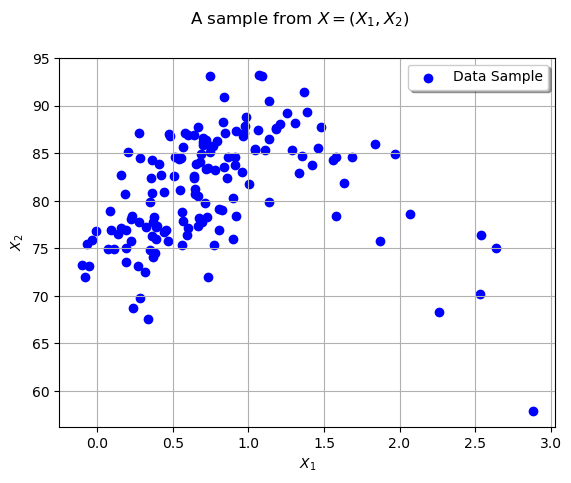

In [14]:
#Modelo de Copula

distX=ot.ComposedDistribution([estimated_kernel_var1,estimated_kernel_var2], KernelSmoothing_copula_distribution)

#Muestra del modelo de copula

sample = distX.getSample(len(sample))

kernel = ot.KernelSmoothing(kernel_distribution) #Estimación 
estimated=kernel.build(sample) #Estimación

graph = ot.Graph("Scatterplot", label_var1, label_var2, True, "topright")
cloud = ot.Cloud(sample, "blue", "fcircle","Data Sample")
graph.add(cloud)
graph.setXTitle("$X_1$")
graph.setYTitle("$X_2$")
graph.setTitle("A sample from $X=(X_1, X_2)$")
view=otv.View(graph)
view.save("222_scatterplot.png",dpi=200)

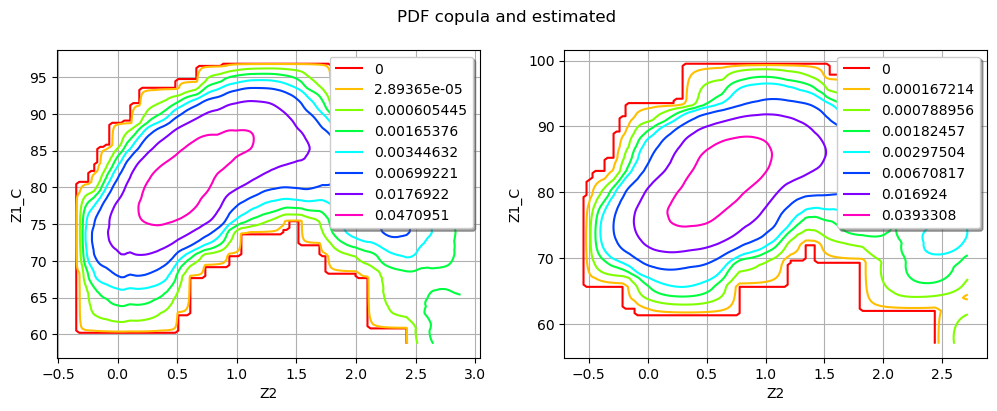

In [15]:
fig = plt.figure(figsize=(12, 4))
ax_pdf = fig.add_subplot(1, 2, 1)
_ = otv.View(distX.drawPDF(), figure=fig, axes=[ax_pdf])

ax_cdf = fig.add_subplot(1, 2, 2)
_ = otv.View(estimated.drawPDF(), figure=fig, axes=[ax_cdf])
_ = fig.suptitle("PDF copula and estimated")

**Estimación de cuantil condicional:**

In [16]:
N = 300
xobs = np.linspace(0, 3, N)
sampleObs = ot.Sample([[xi] for xi in xobs])

In [17]:
x = [xi for xi in xobs]
yapp = [estimated.computeConditionalQuantile(0.5, sampleObs[i]) for i in range(N)] #mediana
yex = [distX.computeConditionalQuantile(0.5, sampleObs[i]) for i in range(N)] #mediana

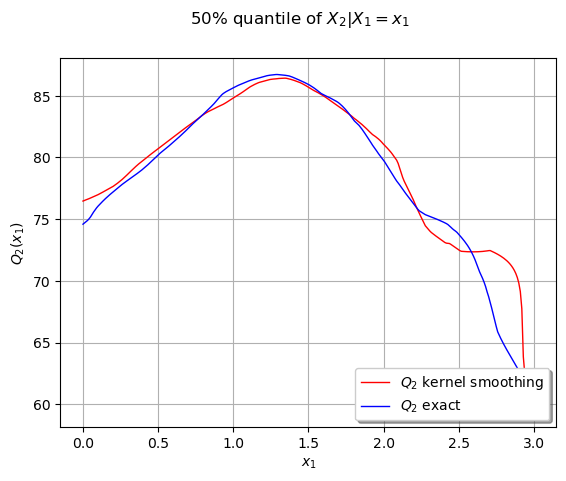

In [18]:
cxy_app = ot.Curve(x, yapp)
cxy_ex = ot.Curve(x, yex)
graph = ot.Graph("50% quantile of $X_2 | X_1=x_1$", "$x_1$", "$Q_2(x_1)$", True, "")
graph.add(cxy_app)
graph.add(cxy_ex)
graph.setLegends(["$Q_2$ kernel smoothing", "$Q_2$ exact"])
graph.setLegendPosition("lower right")
graph.setColors(["red", "blue"])
view = otv.View(graph)

**Estimación en datos de prueba:** Acá se estima con el modelo de copula con los valores de Z2 conocidos (ver PUNTO 3).

In [19]:
df2 = pd.read_csv("datos_banco_test.csv", sep=",")

columnas= ["Z2","Z1_C"]
df3 = df2[columnas]
df4 = df3.dropna()
df4.head()

,Z2,Z1_C
0,1.59666,88.294770
1,2.53552,69.339002
2,0.47840,85.589852
3,0.78039,84.709192
4,0.96278,88.288731


In [20]:
z2 = np.array(df4["Z2"])
N = len(df4["Z2"]) #número de datos
xobs = z2 #observaciones conocidas de Z2
sampleObs2 = ot.Sample([[xi] for xi in xobs]) #muestra de Z2

In [21]:
x = [xi for xi in xobs]
yapp = [estimated.computeConditionalQuantile(0.50, sampleObs2[i]) for i in range(N)] #Estimación de la copula

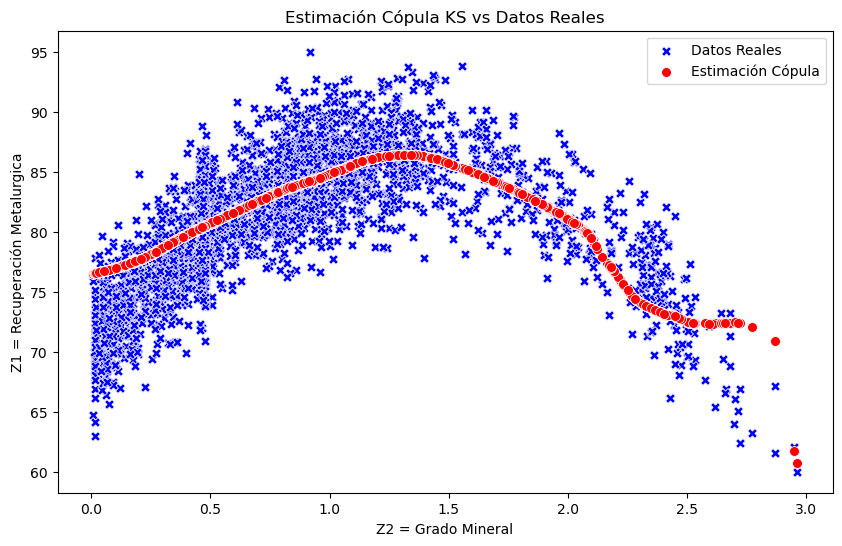

In [22]:
data_estimacion = pd.DataFrame({'Z2': z2, 'Z1_C': yapp})
data_real = df4[['Z2', 'Z1_C']]

plt.figure(figsize=(10, 6))

sns.scatterplot(data=data_real, x='Z2', y='Z1_C', color='blue', label='Datos Reales', s=50, marker="X")  # Ajustar el tamaño con s=

sns.scatterplot(data=data_estimacion, x='Z2', y='Z1_C', color='red', label='Estimación Cópula', s=50)  # Ajustar el tamaño con s=

plt.xlabel('Z2 = Grado Mineral')
plt.ylabel('Z1 = Recuperación Metalurgica')
plt.title('Estimación Cópula KS vs Datos Reales')
plt.legend()

plt.show()
